# Solution 1/3: Tracking by detection and simple frame-by-frame matching

You could also run this notebook on your laptop, a GPU is not needed.

## Import packages

In [1]:
# Force keras to run on CPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# Notebook at full width in the browser
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import sys
from urllib.request import urlretrieve
from pathlib import Path
from collections import defaultdict
from abc import ABC, abstractmethod

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams["image.interpolation"] = "none"
matplotlib.rcParams['figure.figsize'] = (14, 10)
import numpy as np
from tifffile import imread, imwrite
from tqdm.auto import tqdm
import skimage
import pandas as pd
import scipy

from stardist import fill_label_holes, random_label_cmap
from stardist.plot import render_label
from stardist.models import StarDist2D
from stardist import _draw_polygons
from csbdeep.utils import normalize

import napari

lbl_cmap = random_label_cmap()
# Pretty tqdm progress bars 
! jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
def plot_img_label(img, lbl, img_title="image", lbl_title="label", **kwargs):
    fig, (ai,al) = plt.subplots(1,2, gridspec_kw=dict(width_ratios=(1,1)))
    im = ai.imshow(img, cmap='gray', clim=(0,1))
    ai.set_title(img_title)
    ai.axis("off")
    al.imshow(render_label(lbl, img=.3*img, normalize_img=False, cmap=lbl_cmap))
    al.set_title(lbl_title)
    al.axis("off")
    plt.tight_layout()
    
def preprocess(X, Y, axis_norm=(0,1)):
    # normalize channels independently
    X = np.stack([normalize(x, 1, 99.8, axis=axis_norm) for x in tqdm(X, leave=True, desc="Normalize images")])
    # fill holes in labels
    Y = np.stack([fill_label_holes(y) for y in tqdm(Y, leave=True, desc="Fill holes in labels")])
    return X, Y

## Inspect the dataset

In [3]:
base_path = Path("data/exercise1")

In [4]:
x = np.stack([imread(xi) for xi in sorted((base_path / "images").glob("*.tif"))])  # images
y = np.stack([imread(yi) for yi in sorted((base_path / "gt_tracking").glob("*.tif"))])  # ground truth annotations
assert x.shape == y.shape
print(f"Number of images: {len(x)}")
print(f"Shape of images: {x[0].shape}")
x, y = preprocess(x, y)

Number of images: 18
Shape of images: (724, 1024)


Normalize images:   0%|          | 0/18 [00:00<?, ?it/s]

Fill holes in labels:   0%|          | 0/18 [00:00<?, ?it/s]

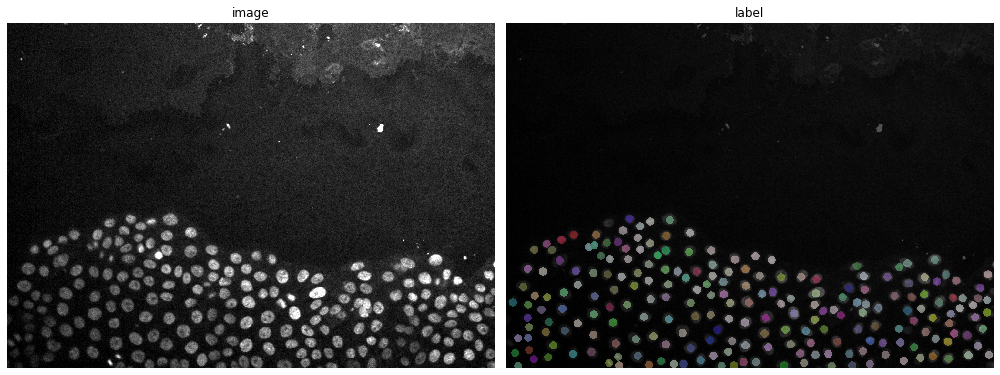

In [5]:
idx = 0
plot_img_label(x[idx], y[idx])

In [6]:
viewer = napari.Viewer()
viewer.add_image(x, name="image");

INFO:OpenGL.acceleratesupport:OpenGL_accelerate module loaded
INFO:OpenGL.arrays.arraydatatype:Using accelerated ArrayDatatype


<div class="alert alert-block alert-danger"><h3>Napari in a jupyter notebook:</h3>
    
- To have napari working in a jupyter notebook, you need to use up-to-date versions of napari, pyqt and pyqt5, as is the case in the conda environments provided together with this exercise.
- When you are coding and debugging, close the napari viewer with `viewer.close()` to avoid problems with the two event loops of napari and jupyter.
- **If a cell is not executed (empty square brackets on the left of a cell) despite you running it, running it a second time right after will usually work.**
</div>

In [8]:
viewer.add_labels(y, name="labels");

In [9]:
links = np.loadtxt(base_path / "gt_tracking" / "man_track.txt", dtype=int)
links = pd.DataFrame(data=links, columns=["track_id", "from", "to", "parent_id"])
print("Links")
links[:10]

Links


,track_id,from,to,parent_id
0,9,1,17,8
1,10,1,17,8
2,12,1,17,11
3,13,1,17,11
4,15,17,17,14
5,16,17,17,14
6,19,15,17,18
7,20,15,17,18
8,32,14,17,31
9,33,14,17,31


In [10]:
def visualize_tracks(viewer, y, links=None, name=""):
    """Utility function to visualize segmentation and tracks"""
    max_label = max(links.max(), y.max()) if links is not None else y.max()
    colorperm = np.random.default_rng(42).permutation((np.arange(1, max_label + 2)))
    tracks = []
    for t, frame in enumerate(y):
        centers = skimage.measure.regionprops(frame)
        for c in centers:
            tracks.append([colorperm[c.label], t, int(c.centroid[0]), int(c.centroid[1])])
    tracks = np.array(tracks)
    tracks = tracks[tracks[:, 0].argsort()]
    
    graph = {}
    if links is not None:
        divisions = links[links[:,3] != 0]
        for d in divisions:
            if colorperm[d[0]] not in tracks[:, 0] or colorperm[d[3]] not in tracks[:, 0]:
                continue
            graph[colorperm[d[0]]] = [colorperm[d[3]]]

    viewer.add_labels(y, name=f"{name}_detections")
    viewer.layers[f"{name}_detections"].contour = 3
    viewer.add_tracks(tracks, name=f"{name}_tracks", graph=graph)
    return tracks

In [13]:
viewer = napari.viewer.current_viewer()
if viewer:
    viewer.close()
viewer = napari.Viewer()
viewer.add_image(x)
visualize_tracks(viewer, y, links.to_numpy(), "ground_truth");

## Exercise 1.1
<div class="alert alert-block alert-info"><h3>Exercise 1.1: Highlight the cell divisions</h3>

In [ ]:
# Solution Exercise 1.1
def visualize_divisions(viewer, y, links):
    """Utility function to visualize divisions"""
    daughters = links[links[:,3] != 0]
    divisions = np.zeros_like(y)

    for d in daughters:
        if d[0] not in y or d[3] not in y:
            continue
        divisions[d[1]][y[d[1]] == d[0]] = d[0]
                
    viewer.add_labels(divisions, name="divisions")
    return divisions

In [ ]:
visualize_divisions(viewer, y, links.to_numpy());

## Object detection using a pre-trained neural network

In [ ]:
idx = 0
model = StarDist2D(None, name="stardist_breast_cancer", basedir="models")
(detections, details), (prob, _) = model.predict_instances(x[idx], scale=(1, 1), return_predict=True)
plot_img_label(x[idx], detections, lbl_title="detections")

In [ ]:
coord, points, polygon_prob = details['coord'], details['points'], details['prob']
plt.figure(figsize=(24,12))
plt.subplot(121)
plt.title("Predicted Polygons")
_draw_polygons(coord, points, polygon_prob, show_dist=True)
plt.imshow(x[idx], cmap='gray'); plt.axis('off')

plt.subplot(122)
plt.title("Object center probability")
plt.imshow(prob, cmap='magma'); plt.axis('off')
plt.tight_layout()
plt.show() 

## Exercise 1.2
<div class="alert alert-block alert-info"><h3>Exercise 1.2: Explore the parameters of cell detection</h3></div>

In [ ]:
scale = (1.0, 1.0)
pred = [model.predict_instances(xi, show_tile_progress=False, scale=scale)
              for xi in tqdm(x)]
detections = [xi[0] for xi in pred]
detections = np.stack([skimage.segmentation.relabel_sequential(d)[0] for d in detections])  # ensure that label ids are contiguous and start at 1 for each frame 
centers = [xi[1]["points"] for xi in pred]

In [ ]:
viewer = napari.viewer.current_viewer()
if viewer:
    viewer.close()
viewer = napari.Viewer()
viewer.add_image(x)
viewer.add_labels(detections, name=f"detections_scale_{scale}");

In [ ]:
plt.figure(figsize=(10,6))
plt.bar(range(len(centers)), [len(xi) for xi in centers])
plt.title(f"Number of detections in each frame (scale={scale})")
plt.xticks(range(len(centers)))
plt.show();

## Checkpoint 1
<div class="alert alert-block alert-success"><h3>Checkpoint 1: We have good detections, now on to the linking.</h3></div>

## Greedy linking by nearest neighbor

## Exercise 1.3
<div class="alert alert-block alert-info"><h3>Exercise 1.3: Write a function that computes pairwise euclidian distances given two lists of points</h3></div>

In [ ]:
# Solution Exercise 1.3

def pairwise_euclidian_distance(points0, points1):
    print("Iterative pairwise euclidian distance")
    dists = []
    for p0 in points0:
        for p1 in points1:
            dists.append(np.sqrt(((p0 - p1)**2).sum()))
            
    dists = np.array(dists).reshape(len(points0), len(points1))
    return dists

# def pairwise_euclidian_distance(points0, points1):
#     # Numpy-based, but still slow
#     print("Vectorized pairwise euclidian distance")
#     return np.apply_along_axis(
#         np.linalg.norm,
#         2,
#         points0[:, None, :] - points1[None, :, :]
#     )

# def pairwise_euclidian_distance(points0, points1):
#     print("Scipy pairwise euclidian distance")
#     return scipy.spatial.distance.cdist(points0, points1)

In [ ]:
green_points = np.load("points.npz")["green"]
cyan_points = np.load("points.npz")["cyan"]

In [ ]:
%time dists = pairwise_euclidian_distance(green_points, cyan_points)
assert np.allclose(dists, np.load("points.npz")["dists_green_cyan"])

## Exercise 1.4
<div class="alert alert-block alert-info"><h3>Exercise 1.4: Write a function that greedily extracts a nearest neighbors assignment given a cost matrix</h3></div>

In [ ]:
# Solution exercise 1.4

def nearest_neighbor(cost_matrix):
    """Greedy nearest neighbor assignment.
    
    Each point in both sets can only be assigned once. 
    
    Args:

        cost_matrix: m x n matrix with pairwise linking costs of two sets of points.

    Returns:

        Tuple of lists (ids frame t, ids frame t+1).
    """
    print("Iterative nearest neighbor")
    A = cost_matrix.copy().astype(float)
    ids_from = []
    ids_to = []
    for i in range(min(A.shape[0], A.shape[1])):
        row, col = np.unravel_index(A.argmin(), A.shape)
        ids_from.append(row)
        ids_to.append(col)
        A[row, :] = cost_matrix.max() + 1
        A[:, col] = cost_matrix.max() + 1

    return np.array(ids_from), np.array(ids_to)

In [ ]:
test_matrix = np.array([
    [9, 2, 9],
    [9, 9, 9],
    [1, 9, 9],
    [9, 3, 9],
])
idx_from, idx_to = nearest_neighbor(test_matrix)
assert np.all(idx_from == [2, 0, 1])
assert np.all(idx_to == [0, 1, 2])

## Exercise 1.5
<div class="alert alert-block alert-info"><h3>Exercise 1.5: Complete a thresholded nearest neighbor linker using your functions from exercises 1.3 and 1.4</h3></div>

In [ ]:
class FrameByFrameLinker(ABC):
    """Abstract base class for linking detections by considering pairs of adjacent frames."""
    
    def link(self, detections, images=None):
        """Links detections in t frames.
        
        Args:
        
            detections:
            
                List of t numpy arrays of shape (x,y) with contiguous label ids. Background = 0.
                
            images (optional):
            
                List of t numpy arrays of shape (x,y).
        
        Returns:
        
            List of t linking dictionaries, each containing:
                "links": Tuple of lists (ids frame t, ids frame t+1),
                "births": List of ids,
                "deaths": List of ids.
            Ids are one-based, 0 is reserved for background.
        """
        if images is not None:
            assert len(images) == len(detections)
        else:
            images = [None] * len(detections)

        links = []
        for i in tqdm(range(len(images) - 1), desc="Linking"):
            detections0 = detections[i]
            detections1 = detections[i+1]
            self._assert_relabeled(detections0)
            self._assert_relabeled(detections1)
            
            cost_matrix = self.linking_cost_function(detections0, detections1, images[i], images[i+1])
            li = self._link_two_frames(cost_matrix)
            self._assert_links(links=li, time=i, detections0=detections0, detections1=detections1) 
            links.append(li)
            
        return links

    @abstractmethod
    def linking_cost_function(self, detections0, detections1, image0=None, image1=None):
        """Calculate features for each detection and extract pairwise costs.
        
        To be overwritten in subclass.
        
        Args:
        
            detections0: image with background 0 and detections 1, ..., m
            detections1: image with backgruond 0 and detections 1, ..., n
            image0 (optional): image corresponding to detections0
            image1 (optional): image corresponding to detections1
            
        Returns:
        
            m x n cost matrix 
        """
        pass
    
    @abstractmethod
    def _link_two_frames(self, cost_matrix):
        """Link two frames.
        
        To be overwritten in subclass.

        Args:

            cost_matrix: m x n matrix

        Returns:
        
            Linking dictionary:
                "links": Tuple of lists (ids frame t, ids frame t+1),
                "births": List of ids,
                "deaths": List of ids.
            Ids are one-based, 0 is reserved for background.
        """
        pass

    def relabel_detections(self, detections, links):
        """Relabel dense detections according to computed links, births and deaths.
        
        Args:
        
            detections: 
                 
                 List of t numpy arrays of shape (x,y) with contiguous label ids. Background = 0.
                 
            links:
                
                List of t linking dictionaries, each containing:
                    "links": Tuple of lists (ids frame t, ids frame t+1),
                    "births": List of ids,
                    "deaths": List of ids.
                Ids are one-based, 0 is reserved for background.
        """
        detections = detections.copy()
        
        assert len(detections) - 1 == len(links)
        self._assert_relabeled(detections[0])
        out = [detections[0]]
        n_tracks = out[0].max()
        lookup_tables = [{i: i for i in range(1, out[0].max() + 1)}]

        for i in tqdm(range(len(links)), desc="Recoloring detections"):
            (ids_from, ids_to) = links[i]["links"]
            births = links[i]["births"]
            deaths = links[i+1]["deaths"] if i+1 < len(links) else []
            new_frame = np.zeros_like(detections[i+1])
            self._assert_relabeled(detections[i+1])
            
            lut = {}
            for _from, _to in zip(ids_from, ids_to):
                # Copy over ID
                new_frame[detections[i+1] == _to] = lookup_tables[i][_from]
                lut[_to] = lookup_tables[i][_from]

            
            # Start new track for birth tracks
            for b in births:
                if b in deaths:
                    continue
                
                n_tracks += 1
                lut[b] = n_tracks
                new_frame[detections[i+1] == b] = n_tracks
                
            # print(lut)
            lookup_tables.append(lut)
            out.append(new_frame)
                
        return np.stack(out)

    def _assert_links(self, links, time, detections0, detections1):
        if len(links["links"][0]) != len(links["links"][1]):
            raise RuntimeError("Format of links['links'] not correct.")
            
        if sorted([*links["links"][0], *links["deaths"]]) != list(range(1, len(np.unique(detections0)))):
            raise RuntimeError(f"Some detections in frame {time} are not properly assigned as either linked or death.")
            
        if sorted([*links["links"][1], *links["births"]]) != list(range(1, len(np.unique(detections1)))):
            raise RuntimeError(f"Some detections in frame {time + 1} are not properly assigned as either linked or birth.")
            
        for b in links["births"]:
            if b in links["links"][1]:
                raise RuntimeError(f"Links frame {time+1}: Detection {b} marked as birth, but also linked.")
        
        for d in links["deaths"]:
            if d in links["links"][0]:
                raise RuntimeError(f"Links frame {time}: Detection {d} marked as death, but also linked.")
        
        
    def _assert_relabeled(self, x):
        if x.min() < 0:
            raise ValueError("Negative ID in detections.")
        if x.min() == 0:
            n = x.max() + 1
        else:
            n = x.max()
        if n != len(np.unique(x)):
            raise ValueError("Detection IDs are not contiguous.")

In [ ]:
# Solution Exercise 1.5

class NearestNeighborLinkerEuclidian(FrameByFrameLinker):
    """.
    
    Args:
    
        threshold (float): Maximum euclidian distance for linking.
    """
    
    def __init__(self, threshold=sys.float_info.max, *args, **kwargs):
        self.threshold = threshold
        super().__init__(*args, **kwargs)
    
    def linking_cost_function(self, detections0, detections1, image0=None, image1=None):
        """ Get centroids from detections and compute pairwise euclidian distances.
                
        Args:
        
            detections0: image with background 0 and detections 1, ..., m
            detections1: image with backgruond 0 and detections 1, ..., n
            
        Returns:
        
            m x n cost matrix 
        """
        # regionprops regions are sorted by label
        regions0 = skimage.measure.regionprops(detections0)
        points0 = [np.array(r.centroid) for r in regions0]
        
        regions1 = skimage.measure.regionprops(detections1)
        points1 = [np.array(r.centroid) for r in regions1]
        
        dists = []
        for p0 in points0:
            for p1 in points1:
                dists.append(np.sqrt(((p0 - p1)**2).sum()))

        dists = np.array(dists).reshape(len(points0), len(points1))
        
        return dists
    
    def _link_two_frames(self, cost_matrix):
        """Greedy nearest neighbor assignment.

        Each point in both sets can only be assigned once. 

        Args:

            cost_matrix: m x n matrix containing pairwise linking costs of two sets of points.

        Returns:
            Linking dictionary:
                "links": Tuple of lists (ids frame t, ids frame t+1),
                "births": List of ids,
                "deaths": List of ids.
            Ids are one-based, 0 is reserved for background.
        """
        A = cost_matrix.copy().astype(float)
        ids_from = []
        ids_to = []
        for i in range(min(A.shape[0], A.shape[1])):
            if A.min() >= self.threshold:
                break
            row, col = np.unravel_index(A.argmin(), A.shape)
            ids_from.append(row)
            ids_to.append(col)
            A[row, :] = cost_matrix.max() + 1
            A[:, col] = cost_matrix.max() + 1

        ids_from = np.array(ids_from)
        ids_to = np.array(ids_to)
        births = np.array(list(set(range(A.shape[1])) - set(ids_to)))
        deaths = np.array(list(set(range(A.shape[0])) - set(ids_from)))
        
        # Account for +1 offset of the dense labels
        ids_from += 1
        ids_to += 1
        births += 1
        deaths += 1
        
        links = {"links": (ids_from, ids_to), "births": births, "deaths": deaths}
        return links

In [ ]:
# nn_linker = NearestNeighborLinkerEuclidian(threshold=1000) # Explore different values of `threshold`
nn_linker = NearestNeighborLinkerEuclidian(threshold=50) # Solution param
nn_links = nn_linker.link(detections)
nn_tracks = nn_linker.relabel_detections(detections, nn_links)

In [ ]:
viewer = napari.viewer.current_viewer()
if viewer:
    viewer.close()
viewer = napari.Viewer()
viewer.add_image(x)
visualize_tracks(viewer, nn_tracks, name="nn");

## Checkpoint 2
<div class="alert alert-block alert-success"><h3>Checkpoint 2: We built a basic tracking algorithm from scratch :).</h3></div>

## Exercise 1.6
<div class="alert alert-block alert-info"><h3>Exercise 1.6: Estimate the global drift of the data</h3></div>

In [ ]:
# Solution Exercise 1.6

class NearestNeighborLinkerDriftCorrection(NearestNeighborLinkerEuclidian):
    """.
    
    Args:
        
        drift: tuple of (x,y) drift correction per frame.
    """
    
    def __init__(self, drift, *args, **kwargs):
        self.drift = np.array(drift)
        super().__init__(*args, **kwargs)
        
    def linking_cost_function(self, detections0, detections1, image0=None, image1=None):
        """ Get centroids from detections and compute pairwise euclidian distances with drift correction.
                
        Args:
        
            detections0: image with background 0 and detections 1, ..., m
            detections1: image with backgruond 0 and detections 1, ..., n
            
        Returns:
        
            m x n cost matrix 
        """
        # regionprops regions are sorted by label
        regions0 = skimage.measure.regionprops(detections0)
        points0 = [np.array(r.centroid) for r in regions0]
        
        regions1 = skimage.measure.regionprops(detections1)
        points1 = [np.array(r.centroid) for r in regions1]
        
        dists = []
        for p0 in points0:
            for p1 in points1:
                dists.append(np.sqrt(((p0 + self.drift - p1)**2).sum()))

        dists = np.array(dists).reshape(len(points0), len(points1))
        
        return dists

In [ ]:
# Explore different values of `threshold` and `drift`
drift_linker = NearestNeighborLinkerDriftCorrection(threshold=50, drift=(-20, 0)) # SOLUTION params
drift_links = drift_linker.link(detections)
drift_tracks = drift_linker.relabel_detections(detections, drift_links)

In [ ]:
viewer = napari.viewer.current_viewer()
if viewer:
    viewer.close()
viewer = napari.Viewer()
viewer.add_image(x)
visualize_tracks(viewer, drift_tracks, name="drift");

## Optimal frame-by-frame matching (*Linear assignment problem* or *Weighted bipartite matching*)

## Exercise 1.7
<div class="alert alert-block alert-info"><h3>Exercise 1.7: Perform optimal frame-by-frame linking</h3></div>

In [ ]:
# Solution exercise 1.7

class BipartiteMatchingLinker(FrameByFrameLinker):
    """.
    
    Args:
        threshold (float): Maximum euclidian distance for linking.
        drift: tuple of (x,y) drift correction per frame.
        birth_cost_factor (float): Multiply factor with maximum entry in cost matrix.
        death_cost_factor (float): Multiply factor with maximum entry in cost matrix.
    """
    
    def __init__(
        self,
        threshold=sys.float_info.max,
        drift=(0,0),
        birth_cost_factor=1.05,
        death_cost_factor=1.05,
        *args,
        **kwargs
    ):
        self.threshold = threshold
        self.drift = np.array(drift)
        self.birth_cost_factor = birth_cost_factor
        self.death_cost_factor = death_cost_factor
        
        super().__init__(*args, **kwargs)
        
    def linking_cost_function(self, detections0, detections1, image0=None, image1=None):
        """ Get centroids from detections and compute pairwise euclidian distances with drift correction.
                
        Args:
        
            detections0: image with background 0 and detections 1, ..., m
            detections1: image with backgruond 0 and detections 1, ..., n
            
        Returns:
        
            m x n cost matrix 
        """
        # regionprops regions are sorted by label
        regions0 = skimage.measure.regionprops(detections0)
        points0 = [np.array(r.centroid) for r in regions0]
        
        regions1 = skimage.measure.regionprops(detections1)
        points1 = [np.array(r.centroid) for r in regions1]
        
        dists = []
        for p0 in points0:
            for p1 in points1:
                dists.append(np.sqrt(((p0 + self.drift - p1)**2).sum()))

        dists = np.array(dists).reshape(len(points0), len(points1))
        
        return dists
    
    def _link_two_frames(self, cost_matrix):
        """Weighted bipartite matching with square matrix from Jaqaman et al (2008).

        Args:

            cost_matrix: m x n matrix.

        Returns:
        
            Linking dictionary:
                "links": Tuple of lists (ids frame t, ids frame t+1),
                "births": List of ids,
                "deaths": List of ids.
            Ids are one-based, 0 is reserved for background.
        """
        
        cost_matrix = cost_matrix.copy().astype(float)
        b = self.birth_cost_factor * min(self.threshold, cost_matrix.max())
        d = self.death_cost_factor * min(self.threshold, cost_matrix.max())
        no_link = max(cost_matrix.max(), max(b, d)) * 1e9
        
        cost_matrix[cost_matrix > self.threshold] = no_link
        lower_right = cost_matrix.transpose()

        deaths = np.full(shape=(cost_matrix.shape[0], cost_matrix.shape[0]), fill_value=no_link)
        np.fill_diagonal(deaths, d)
        births = np.full(shape=(cost_matrix.shape[1], cost_matrix.shape[1]), fill_value=no_link)
        np.fill_diagonal(births, b)
        
        square_cost_matrix = np.block([
            [cost_matrix, deaths],
            [births, lower_right],
        ])
        row_ind, col_ind = scipy.optimize.linear_sum_assignment(square_cost_matrix)
        
        ids_from = []
        ids_to = []
        births = []
        deaths = []
        for row, col in zip(row_ind, col_ind):
            if row < cost_matrix.shape[0] and col < cost_matrix.shape[1]:
                ids_from.append(row)
                ids_to.append(col)

            if row >= cost_matrix.shape[0] and col < cost_matrix.shape[1]:
                births.append(col)
            if row < cost_matrix.shape[0] and col >= cost_matrix.shape[1]:
                deaths.append(row)

        ids_from = np.array(ids_from)
        ids_to = np.array(ids_to)
        births = np.array(births)
        deaths = np.array(deaths)
                        
        # Account for +1 offset of the dense labels
        ids_from += 1
        ids_to += 1
        births += 1
        deaths += 1
        
        links = {"links": (ids_from, ids_to), "births": births, "deaths": deaths}
        return links

In [ ]:
bm_linker = BipartiteMatchingLinker(threshold=50, drift=(-20, 0), birth_cost_factor=1.05, death_cost_factor=1.05)
bm_links = bm_linker.link(detections)
bm_tracks = bm_linker.relabel_detections(detections, bm_links)

In [ ]:
viewer = napari.viewer.current_viewer()
if viewer:
    viewer.close()
viewer = napari.Viewer()
viewer.add_image(x)
visualize_tracks(viewer, bm_tracks, name="bm");